In [1]:
import os
import math
import time
import glob
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from metrics import *
from GAT import *
from GraphSAGE import *

In [ ]:
seed = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device=="cuda":
    torch.cuda.manual_seed(seed)

## Loading Datset

In [ ]:
dblp = pickle.load(open("data/all_data_cora.pkl", 'rb'))

adjs = dblp['adjs']
idx_train, idx_val, idx_test = dblp['idx_train'], dblp['idx_val'], dblp['idx_test']
features = torch.from_numpy(dblp['features']).to(device)
labels = torch.from_numpy(dblp['labels']).to(device)

## Parameters

In [ ]:
nclass = int(labels.max())+1
nnode = features.shape[0]
nfeat = features.shape[1]
nchannel = len(adjs)

hid_dim = 64 #8
nneighbor = [500]*nchannel
nsample = [int(len(idx_train)/1), int(len(idx_val)/1), len(idx_test)]
nhead = 8
dropout = 0.6
alpha = 0.2
lr = 0.005
weight_decay = 0.001

patience = 50
epochs = 100000

## Train / Test Function

In [ ]:
adj = adjs[0]
samples = np.sort(np.concatenate([idx_train, idx_val]))
sample_dict = {k:v for v,k in enumerate(samples)}
all_sample_pairs = []
for each, neighbor_size in enumerate(adj[1]):
    if each not in samples: continue
    start = adj[1][:each].sum()
    curr_neighbors = adj[0][start:start+neighbor_size]
    all_sample_pairs.append([[sample_dict[each],sample_dict[neighbor]] for neighbor in curr_neighbors if neighbor in samples])
all_sample_pairs = [each for chunk in all_sample_pairs for each in chunk]
all_sample_pairs = np.array(all_sample_pairs).T

def edge_diff(embeds):
    emb_diff = mean_squared_error(embeds[all_sample_pairs[0]], embeds[all_sample_pairs[1]])
    return emb_diff

In [ ]:
def train(model, optimizer, curr_adjs, epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    
    real_idx_train = np.sort(idx_train[:nsample[0]])
    np.random.shuffle(idx_train)
    real_idx_val = np.sort(idx_val[:nsample[1]])
    np.random.shuffle(idx_val)

    samples = np.sort(np.concatenate([real_idx_train, real_idx_val]))
    index_dict = {k:v for v,k in enumerate(samples)}
    real_train_idx = [index_dict[k] for k in real_idx_train], 
    real_val_idx = [index_dict[k] for k in real_idx_val]
    
    embeds = model(features, curr_adjs, samples)
    diff = edge_diff(embeds.detach().cpu().numpy())
    
    output = F.log_softmax(embeds, dim=1)
    
    loss_train = F.nll_loss(output[real_train_idx], labels[real_idx_train])
    loss_val = F.nll_loss(output[real_val_idx], labels[real_idx_val])        
    acc_train = accuracy_singlelabel(output[real_train_idx], labels[real_idx_train])        
    acc_val = accuracy_singlelabel(output[real_val_idx], labels[real_idx_val])
    
    loss_train.backward()
    optimizer.step()
    
    if (epoch+1)%1==0:
        print('Epoch: {} ||'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.data[0]),
          'acc_train: {:.4f}'.format(acc_train[0]),
          'f1_train: {:.4f} ||'.format(acc_train[1]),
          'loss_val: {:.4f}'.format(loss_val.data[0]),
          'acc_val: {:.4f}'.format(acc_val[0]),
          'f1_val: {:.4f}'.format(acc_val[1]),
          'diff_val: {:.4f} ||'.format(diff),
          'time: {:.4f}s'.format(time.time() - t))
    
    return loss_val.data[0].item(), diff

In [ ]:
def test(model, curr_adjs):
    real_idx_test = np.sort(idx_test[:nsample[2]])
    np.random.shuffle(idx_test)
    
    model.eval()
    output = F.log_softmax(model(features, curr_adjs, real_idx_test), dim=1)
    
    loss_test = F.nll_loss(output, labels[real_idx_test])
    acc_test = accuracy_singlelabel(output, labels[real_idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data[0]),
          'acc_test: {:.4f}'.format(acc_test[0]),
          'f1_test: {:.4f}'.format(acc_test[1]))
    return (loss_test.data[0].item(), acc_test[0], acc_test[1])

## Train

In [ ]:
meta = 0
results = []
t_total = time.time()

#model = GraphSAGEModel(nfeat, hid_dim, nclass, dropout, device, nneighbor[meta])
model = GATModel(nfeat, hid_dim, nclass, dropout, alpha, device, nhead, nneighbor[meta])
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

loss_values, diff_values = [], []
bad_counter, best, best_epoch = 0, epochs+1, 0
for epoch in range(epochs):
    loss_value, diff_value = train(model, optimizer, adjs[meta][:2], epoch)
    loss_values.append(loss_value)
    diff_values.append(diff_value)
    torch.save(model.state_dict(), 'model/cora/GraphSAGE/{}_{}.pkl'.format(meta, epoch))
    
    if loss_values[-1] < best:
        best, best_epoch, bad_counter = loss_values[-1], epoch, 0
    else:
        bad_counter += 1
                
    if bad_counter == patience:
        break
        
    files = glob.glob('model/cora/GraphSAGE/{}_*.pkl'.format(meta))
    for file in files:
        epoch_nb = int(file.split('.')[0].split('_')[-1])
        if epoch_nb < best_epoch:
            os.remove(file) 
    
files = glob.glob('model/cora/GraphSAGE/{}_*.pkl'.format(meta))
for file in files:
    epoch_nb = int(file.split('.')[0].split('_')[-1])
    if epoch_nb > best_epoch:
        os.remove(file) 
        
print("Meta {} Optimization Finished!".format(meta))
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load('model/cora/GraphSAGE/{}_{}.pkl'.format(meta, best_epoch)))

results.append(test(model, adjs[meta][:2]))
pickle.dump(results, open('data/cora_GraphSAGE_{}_results.pkl'.format(meta), 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(diff_values, open('data/cora_GraphSAGE_{}_valdiffs.pkl'.format(meta), 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

## Diff Plot

In [5]:
meta = 0
gat_diff = pickle.load(open('data/cora_GAT_{}_valdiffs.pkl'.format(meta), 'rb'))
sage_diff = pickle.load(open('data/cora_GraphSAGE_{}_valdiffs.pkl'.format(meta), 'rb'))

Text(0.5, 1.0, 'GAT: Change in MSE of edge pairs in val set')

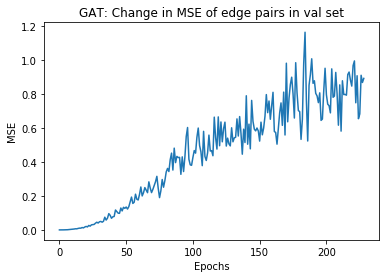

In [6]:
plt.plot(gat_diff)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('GAT: Change in MSE of edge pairs in val set')

Text(0.5, 1.0, 'GraphSAGE: Change in MSE of edge pairs in val set')

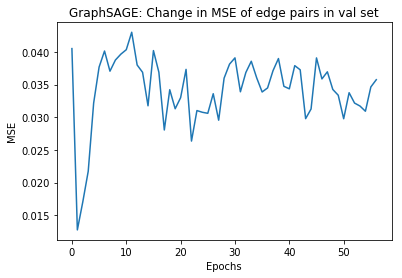

In [7]:
plt.plot(sage_diff)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('GraphSAGE: Change in MSE of edge pairs in val set')